In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [104]:
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras import optimizers
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Activation, LSTM, GRU, GlobalMaxPool1D, Embedding, Dropout, Conv1D
from keras.models import Model, Sequential
#from keras import initializers, regularizers, constraints
from keras.preprocessing import text, sequence

from keras import backend
backend.clear_session()

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
#keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
optimizers.Adam()

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [96]:
df = pd.read_csv('data/drug_review_clean.csv')

In [97]:
df = pd.concat([
                df[df.condition=='Depression'][:2000], 
                df[df.condition=='Birth Control'][:2000],
                df[df.condition=='Pain'][:2000],
                df[df.condition=='Anxiety'][:2000],
                df[df.condition=='Acne'][:2000],
                df[df.condition=='Bipolar Disorde'][:2000],
                df[df.condition=='Insomnia'][:2000],
                df[df.condition=='Weight Loss'][:2000],
                df[df.condition=='Obesity'][:2000],
                df[df.condition=='ADHD'][:2000]
                ])[['condition','review']]

In [98]:
df.condition.value_counts()

Acne               2000
Weight Loss        2000
Obesity            2000
Depression         2000
Anxiety            2000
Birth Control      2000
Insomnia           2000
Bipolar Disorde    2000
ADHD               2000
Pain               2000
Name: condition, dtype: int64

In [99]:
def hot_pad_sequences(text, num_words=2000, maxlen=100):    
    tokenizer = Tokenizer(num_words)
    tokenizer.fit_on_texts(list(text))
    list_tokenized_headlines = tokenizer.texts_to_sequences(text)
    return sequence.pad_sequences(list_tokenized_headlines, maxlen)

In [100]:
def hot_label_encoding(labels):
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    labels_cat = le.transform(labels)
    return to_categorical(labels_cat) 

In [101]:
X_t = hot_pad_sequences(df.review, num_words=2000, maxlen=100)
y = hot_label_encoding(df.condition)

In [102]:
train, test, label_train, label_test = train_test_split(X_t, y, test_size=0.2, random_state=42)

In [94]:
def create_model(dropout_rate=0.2, lr=0.001, neurons=40):
    
    backend.clear_session()
    embedding_size = 128
    input_ = Input(shape=(100,))
    x = Embedding(4000, embedding_size)(input_)
    x = LSTM(25, return_sequences=True)(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(neurons, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(10, activation='softmax')(x)

    model = Model(inputs=input_, outputs=x)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model
 
model = KerasClassifier(build_fn=create_model)

param_grid = dict(
                    lr = [0.01, 0.1], 
                    batch_size = [40, 50], 
                    epochs = [5], 
                    validation_split = [0.1],
                    neurons = [50, 60],
                    dropout_rate = [0.1, 0.3]
                    )

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(train, label_train, verbose=0)


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/Users/seanbird/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best: 0.739375 using {'batch_size': 50, 'dropout_rate': 0.1, 'epochs': 5, 'lr': 0.01, 'neurons': 50, 'validation_split': 0.1}


In [118]:
backend.clear_session()

input_ = Input(shape=(100,))
x = Embedding(2000, 120)(input_)
x = LSTM(25, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=input_, outputs=x)

optimizer = optimizers.Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(train, label_train, epochs=3, validation_split=0.1, batch_size=40)

Train on 14400 samples, validate on 1600 samples
Epoch 1/3
14400/14400 [==============================] - 364s 25ms/step - loss: 1.1513 - acc: 0.5690 - val_loss: 0.7877 - val_acc: 0.7012
Epoch 2/3
14400/14400 [==============================] - 352s 24ms/step - loss: 0.7569 - acc: 0.7203 - val_loss: 0.7330 - val_acc: 0.7219
Epoch 3/3
14400/14400 [==============================] - 243s 17ms/step - loss: 0.7146 - acc: 0.7337 - val_loss: 0.7062 - val_acc: 0.7319


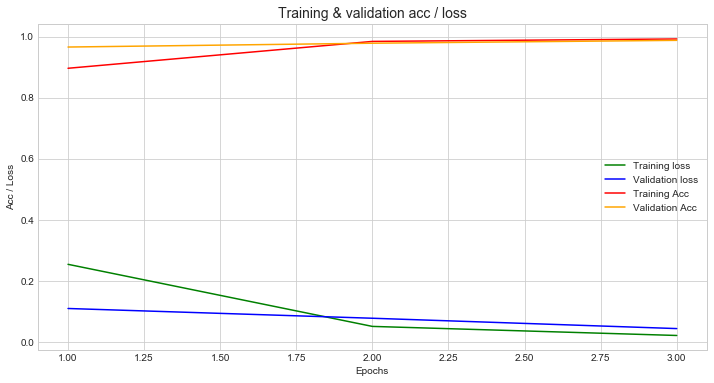

In [77]:
import matplotlib.pyplot as plt
#import seaborn as sns

history_dict = history.history

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(12,6))

epochs = range(1, len(history_dict['loss']) + 1)
plt.plot(epochs, history_dict['loss'], 'g', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'blue', label='Validation loss')

plt.plot(epochs, history_dict['acc'], 'r', label='Training Acc')
plt.plot(epochs, history_dict['val_acc'], 'orange', label='Validation Acc')

plt.title('Training & validation acc / loss',fontSize=14)
plt.xlabel('Epochs')
plt.ylabel('Acc / Loss')
plt.legend()
plt.show()

In [108]:
backend.clear_session()

model = Sequential()
model.add(Embedding(2000, embedding_size, input_length=100))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          256000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           82048     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                5160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                410       
Total para

In [107]:
history = model.fit(train, label_train, epochs=3, validation_split=0.1, batch_size=40)

Train on 14400 samples, validate on 1600 samples
Epoch 1/3
14400/14400 [==============================] - 91s 6ms/step - loss: 1.3648 - acc: 0.5442 - val_loss: 0.8088 - val_acc: 0.7063
Epoch 2/3
14400/14400 [==============================] - 113s 8ms/step - loss: 0.6569 - acc: 0.7648 - val_loss: 0.6538 - val_acc: 0.7563
Epoch 3/3
14400/14400 [==============================] - 119s 8ms/step - loss: 0.4824 - acc: 0.8313 - val_loss: 0.6083 - val_acc: 0.7831


In [109]:
history = model.fit(train, label_train, epochs=3, validation_split=0.1, batch_size=40)

Train on 14400 samples, validate on 1600 samples
Epoch 1/3
14400/14400 [==============================] - 85s 6ms/step - loss: 1.4240 - acc: 0.5110 - val_loss: 0.7933 - val_acc: 0.7112
Epoch 2/3
14400/14400 [==============================] - 96s 7ms/step - loss: 0.7079 - acc: 0.7406 - val_loss: 0.6573 - val_acc: 0.7600
Epoch 3/3
14400/14400 [==============================] - 103s 7ms/step - loss: 0.5388 - acc: 0.8029 - val_loss: 0.6042 - val_acc: 0.7888
